**Part 3 - Mapping Closure in 2D**

This notebook implements the mapping closure developed by (Chen, H. 1989) and extended by (Pope, S.B. 1991) for a two-dimensional (2D) problem where the vector of random variables $\mathbf{Y} = (B,W)$ inlcues the buoyancy $B$ and the vertical velocity $W$.

*Evolution equation*

The joint pdf $f_{\mathbf{Y}}$ evolves according to the forward Kolmogorov equation given by

\begin{equation}
\frac{\partial f_{\mathbf{Y}} }{ \partial t}= -\frac{\partial }{\partial y_i} \mathbf{D}^{(1)}_i f_{\mathbf{Y}}  + \frac{\partial^{2}}{\partial y_i \partial y_j} \mathbf{D}^{(2)}_{ij} f_{\mathbf{Y}},
\end{equation}

where 

\begin{equation}
  \mathbf{D}^{(1)}=
    \begin{pmatrix}
    0\\
    \mathbb{E}_{\mathbf{Y}_{t}} [B_t - \partial_{Z} P_{t}]\\
  \end{pmatrix}
  +
  \phi\,\mathbb{E}_{\mathbf{Y}_{t}|\partial\Omega}
\begin{bmatrix}
  \alpha_{1}\,\mathbf{n}\cdot\nabla B_{t}\\
  \alpha_{2}\,\mathbf{n}\cdot\nabla W_{t}\\
\end{bmatrix} \frac{f_{\mathbf{Y}|\partial\Omega}}{f_{\mathbf{Y}}}.
\end{equation}

arises due to diffusive fluxes at the boundary, which must be specified. In this case buoyancy forcing make a non-zero contribution to $\mathbf{D}^{(1)}$ while $\mathbf{n}\cdot\nabla W_{t} = 0$ for our system, due to no-slip boundary conditions and $\nabla \cdot \mathbf{U} = 0$ so we can discard this term. The diffusion term for our system us given by
\begin{equation}
  \mathbf{D}^{(2)}=-\frac{1}{2}
  \mathbb{E}_{\mathbf{Y}_{t}}
    \begin{bmatrix}
    2\alpha_{1}|\nabla B_{t}|^{2} & (\alpha_{1}+\alpha_{2})\nabla B_{t}\cdot\nabla W_{t} \\
    (\alpha_{1}+\alpha_{2})\nabla B_{t}\cdot\nabla W_{t} & 2\alpha_{2} |\nabla W_{t}|^{2}\\
  \end{bmatrix}.
\end{equation}
However to avail of the mapping closure (Pope, S.B. 1991) we will use to model these terms we will make the assumption that
\begin{equation}
  \frac{\partial^{2}}{\partial y_i \partial y_j} \mathbf{D}_{ij}^{(2)} f_{\mathbf{Y}} \approx -\frac{\partial }{ \partial y_i} \mathbb{E}_{\mathbf{Y}_{t}} [ \alpha_{ij} \nabla^{2} \mathbf{Y}^j_{t}] f_{\mathbf{Y}},
\end{equation}
which at least for the 1D problem has been shown to be equivalent. For now we consider only the unforced system when $\mathbf{D}^{(1)}_{i} = 0$ before later reintroducing these terms.

*Mapping closure*

Corresponding to the random vector $\mathbf{Y} = (Y_1,Y_2)$ we now have a vector of Gaussian random fields $\mathbf{Z} = (Z_1,Z_2)$. The (now multidimensional) mapping $\mathscr{Y}_{\alpha}(-,t):\mathbb{R}^{\alpha} \rightarrow \mathbb{R}$ which maps the Gaussian field(s) to the surrogate field $\tilde{Y}_{\alpha}$ is hierarchical in the sense that 
\begin{align*}
    \tilde{Y}_1(\mathbf{x},t) &= \mathscr{Y}_{1}(Z_1(J_1(t)\mathbf{x}),t), \\
    \tilde{Y}_2(\mathbf{x},t) &= \mathscr{Y}_{2}(Z_1(J_1(t)\mathbf{x}),Z_2(J_2(t)\mathbf{x}),t),
\end{align*}
such that $\mathscr{Y}_{\alpha}$ only depends on the subset $[\mathbf{Z}]_{\alpha}$

*Mapping equation*

The mapping $\mathscr{Y}_{\alpha}(-,t)$ evolves according to

\begin{equation}
\frac{\partial \mathscr{Y}_{\alpha} }{\partial t} = \mathbf{D}^{(1)}_{\alpha} + \sum_{j=1}^{\alpha} \frac{\gamma_{\alpha}}{\tau_{j}(t)} \left( \frac{\partial^{2}}{\partial z_{j}^{2}} - z_{j}\frac{\partial }{ \partial z_{j} }\right)\mathscr{Y}_{\alpha},
\end{equation}

which when expanded is given by

\begin{align*}
\frac{\partial \mathscr{Y}_1 }{\partial t} &= \frac{\gamma_{1}}{\tau_1(t)} \left( \frac{\partial^{2}}{\partial z_{1}^{2}} - z_1\frac{\partial }{ \partial z_1 }\right)\mathscr{Y}_1, \\
\frac{\partial \mathscr{Y}_2 }{\partial t} &= \gamma_2 \left[ \frac{1}{\tau_1(t)} \left( \frac{\partial^{2}}{\partial z_{1}^{2}} - z_1\frac{\partial }{ \partial z_1 }\right) + \frac{1}{\tau_2(t)} \left( \frac{\partial^{2}}{\partial z_{2}^{2}} - z_2\frac{\partial }{ \partial z_2 }\right) \right] \mathscr{Y}_2.
\end{align*}

**Setup**

We first import the required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

For the mapping eqution we define a computational grid, on which the position vector $\mathbf{z} = (z_1,z_2)$ for the Gaussian random variables is defined.  

In [2]:
# Time scales (cf. Taylor microscale)
t1 = 1
t2 = 1

# Boundary conditions
bc1 = 'Neumann'
bc2 = 'Neumann'

# Numerical resolution
N1 =64
N2 =64

# Domain
z1 = np.linspace(-4, 4, N1)
z2 = np.linspace(-4, 4, N2)

# 2d grid for gaussian random variables Y1 and Y2
I2 = np.ones(N2)
I1 = np.ones(N1)
z1_2d = np.kron(z1,I2).reshape((N1,N2))
z2_2d = np.kron(I1,z2).reshape((N1,N2))

*Differential operators*

To define the differential operators in the equations right hand sides we first define the gradient and Laplacian operators:

In [3]:
# Define the gradient & Laplacian operators
def grad(x):
  """Gradient operator ∂/∂x"""
  N = len(x)
  dx= x[1] - x[0] 
  D = np.zeros((N,N))
  for i in range(N):
    if i < N-1:
      D[i,i+1] = 1
    if i > 0:
      D[i,i-1] =-1
  return D/(2*dx)

def laplacian(x, bcs = 'Dirichlet'):
  """Laplacian ∂^2/∂x^2"""
  
  N = len(x)
  dx= x[1] - x[0] 

  L = np.zeros((N,N))
  for i in range(N):

    L[i,i] = -2.
    if i ==N-1:
      if bcs == 'Dirichlet':
        L[i,i-1] = 1
      elif bcs == 'Neumann':
        L[i,i-1] = 2
    elif i == 0:
      if bcs == 'Dirichlet':
        L[i,i+1] = 1
      elif bcs == 'Neumann':
        L[i,i+1] = 2
    else:
      L[i,i-1] = 1
      L[i,i+1] = 1

  return L/(dx**2)

def test_derivatives():
  """Check the derivatives are correctly implemented"""
  
  x = np.linspace(0, 2*np.pi, 256)
  
  D = grad(x)
  error_D = ( np.cos(x)[1:-1] - D.dot(np.sin(x))[1:-1])**2
  assert np.trapezoid(y=error_D,x=x[1:-1]) < 1e-07

  L = laplacian(x)
  error_L = (-np.sin(x)[1:-1] - L.dot(np.sin(x))[1:-1])**2
  assert np.trapezoid(y=error_L,x=x[1:-1]) < 1e-07

  return None

test_derivatives()

Using these operators the terms in the mapping equation are constructed using Kronecker products:

In [4]:
# Define the 1D equation operators 
D1_1d = grad(z1)
L1_1d = laplacian(z1, bcs = bc1)
Z1_1d = np.diag(z1)
I1_1d = np.eye(N1)

D2_1d = grad(z2)
L2_1d = laplacian(z2, bcs = bc2)
Z2_1d = np.diag(z2)
I2_1d = np.eye(N2)

# Take Kronecker products to obtain them in 2D
D1_2d = np.kron(D1_1d,I2_1d)
L1_2d = np.kron(L1_1d,I2_1d)
Z1_2d = np.kron(Z1_1d,I2_1d)

D2_2d = np.kron(I1_1d,D2_1d)
L2_2d = np.kron(I1_1d,L2_1d)
Z2_2d = np.kron(I1_1d,Z2_1d)

These are then assembled to make the right hand side operators for $\mathscr{Y}_1(z_1,t)$ and $\mathscr{Y}_2(z_1,z_2,t)$. For now we ignore the coefficients $\mathbf{D}^{(1)}_{\alpha}$ and concentrate on the differential operators only.

In [5]:
# Define the RHS operator for Y_1
L1 = (1/t1)*(L1_1d - Z1_1d@D1_1d)

# Define the RHS operator for Y_2
L2 = (1/t1)*(L1_2d - Z1_2d@D1_2d) + (1/t2)*(L2_2d - Z2_2d@D2_2d)

*Initial conditions & forcing*

Using $\mathbf{\eta}$ as a dummy variable, this mapping is chosen such that the conditional cumulative distribution function satisfies
\begin{equation}
  F_{\alpha|\alpha-1}(\mathscr{Y}_{\alpha}([\mathbf{z}]_{\alpha},t), t)=G(z_{\alpha}),
\end{equation}
which taking a derivative with respect to $\eta_{\alpha}$ implies that
\begin{equation}
    f_{\alpha|\alpha-1}([\mathbf{y}]_{\alpha},t)\frac{\partial \mathscr{Y}_{\alpha}}{\partial z_{\alpha}}\bigg|_{\mathbf{z}}=g(z_{\alpha})>0,
\end{equation}
and inturn that if the conditional density is strictly positive then $\partial_{\eta_{\alpha}}\mathscr{Y}_{\alpha}>0$.

To prescribe initial conditions for the mapping we make use of these relations by choosing conditional cumulative distribution functions specified in terms of an error function
\begin{align*}
F_1(\tilde{y}_1) &= \frac{1}{2} [ 1 + \text{erf}(\frac{y_1}{\sigma_1 \sqrt{2}})  ], \\
F_{2|1}(\tilde{y}_2) &= \frac{1}{2} [ 1 + \text{erf}(\frac{y_2}{\sigma_2 \sqrt{2}})  ], 
\end{align*}
as this function has a well defined inverse also known as the quantile function of the normal distribution and thus make it easy to invert for $\mathscr{Y}_1, \mathscr{Y}_2$. Implementing these relations below we calculate the initial conditions.

In [6]:
from scipy.special import erf, erfinv

def G(z):
    return (1 + erf(z/np.sqrt(2)))/2

def g(z):
    return np.exp(-z**2/2)/np.sqrt(2*np.pi)

To recover the joint distribution $f_\mathbf{Y}(y1, y2)$ from the mapping we then make use of the second relation above.This is achieved by relating the mapping to the pdf of the Gaussian random variables for
\begin{equation}
    \frac{\partial \mathscr{Y}_1}{\partial \eta_1} f_{Y_1}( \mathscr{Y}_1(y_1,t), t) = g(\eta_1),
\end{equation}
and
\begin{equation}
    \frac{\partial \mathscr{Y}_2}{\partial \eta_2} f_{Y_2|Y_1}( \mathscr{Y}_1(y_1,t), \mathscr{Y}_2(y_1,y_2,t), t) = g(\eta_2),
\end{equation}
and then by inverting $\frac{\partial \mathscr{Y}_1}{\partial \eta_1}$ and $\frac{\partial \mathscr{Y}_2}{\partial \eta_2}$ (by expressing these terms in discrete form as matrices and $f,g$ as vectors) on to the right hand side we recover $f_{Y_1}$ and $f_{Y_2|Y_1}$. The joint desnity is then readily obtained by multiplying these distributions
\begin{equation}
f_\mathbf{Y}(y1, y2) = f_{Y_2|Y_1}(y1, y2) f_{Y_1}(y_1),
\end{equation}
as implemented below along with plotting routines to show the mapping and to show the joint distribution.

In [7]:
# plt.rcParams.update(
#     {"text.usetex": True, 
#      "font.family": "sans-serif", 
#      "font.sans-serif": "Helvetica",
#       'text.latex.preamble': r'\usepackage{amsfonts}'
#      })

# Make the Y1 mapping 2D
def one_to_2d(Y1):
    return np.kron(Y1,I2) 

# Produce the joint pdf and all its marginals from the mapping
def map_to_pdf(z1,Y1,z2_2d,Y2):

    # Invert the mappings
    dY1_dη1 = D1_1d@Y1 
    dY2_dη2 = D2_2d@Y2

    # Gaussian distribution
    g_1 = g(z1)
    g_2 = g(z2_2d).flatten()

    # Conditional pdfs
    fc_1 = g_1/dY1_dη1 # vector size N1
    fc_2 = g_2/dY2_dη2 # vector size N1*N2

    # Compute the marginal pdfs f_1,f_2
    f_1   = fc_1
    y1_1d = Y1
    assert (1 - np.trapezoid(y=f_1,x=y1_1d))**2 < 1e-03

    # f_2   = 
    # y2_1d = 
    # assert (1 - np.trapezoid(y=f_2,x=y2_1d))**2 < 1e-03

    # Compute the joint distribution f_12
    fj_12 = (fc_2*one_to_2d(fc_1)).reshape((N1,N2))

    # Compute the 2d grids
    y1_2d = one_to_2d(Y1).reshape((N1,N2))
    y2_2d = Y2.reshape((N1,N2))

    return y1_1d,f_1, y1_2d,y2_2d,fj_12

# Plot the mapping time-evolution
def plot_mapping(z1,Y1, z1_2d,z2_2d,Y2):
    """Plot the mapping components."""
    fig = plt.figure(figsize=(6,4),layout='constrained')

    ax1 = fig.add_subplot(1, 2, 1,projection="3d")  # equivalent but more general
    ax2 = fig.add_subplot(1, 2, 2)  # equivalent but more general

    # 2D plot for Y2
    surf = ax1.plot_surface(z1_2d,z2_2d, Y2.reshape((N1,N2)), cmap='RdBu',linewidth=0, antialiased=False)
    #fig.colorbar(surf, shrink=0.5, aspect=5,orientation='horizontal')
    ax1.set_title(r'$Y_2$')
    ax1.set_xlabel(r'$z_1$')
    ax1.set_ylabel(r'$z_2$')

    # 1D plot for Y1
    ax2.set_title(r'$Y_1$')
    ax2.plot(z1,Y1)
    ax2.set_xlabel(r'$z_1$')

    plt.show()

    return None

# plot the joint density
def plot_joint(y1_1d,f_1, y1_2d,y2_2d,f_12):
    """Plot the mapping components."""
    fig = plt.figure(figsize=(6,4),layout='constrained')

    ax1 = fig.add_subplot(1, 3, 1)

    # 2D plot for Y2
    # array C with shape (nrows, ncolumns) is plotted with the column number as X and the row number as Y
    pc=ax1.pcolormesh(y1_2d,y2_2d,f_12, cmap='Reds')#,linewidth=0, antialiased=False)
    ax1.set_xlabel(r'$y_1$')
    ax1.set_ylabel(r'$y_2$')
    fig.colorbar(pc)

    ax2 = fig.add_subplot(1, 3, 2) 
    
    ax2.plot(y1_1d,f_1)
    ax2.set_xlabel(r'$y_1$')
    ax2.set_ylabel(r'$f_{Y_1}$')

    # ax3 = fig.add_subplot(1, 3, 3)
    # f_2 = np.zeros(N2)
    # for j in range(N2):
    #     f_2[j] = np.trapezoid(y=f_12[:,j],x=y1[:,j])
    # ax3.plot(y2[0,:],f_2)
    # ax3.set_xlabel(r'$y_2$')
    # ax3.set_ylabel(r'$f_{Y_2}$')

    plt.show()

    return None

We then pass these initial conditions to a time-stepping routine, and time-integrate forwards one time unit. 

time t =  0.0


/tmp/ipykernel_1466/2180677631.py:78: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc=ax1.pcolormesh(y1_2d,y2_2d,f_12, cmap='Reds')#,linewidth=0, antialiased=False)


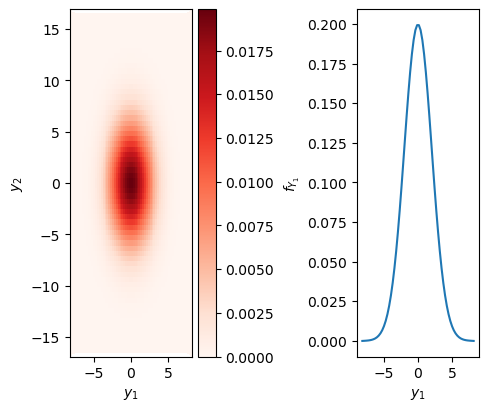

time t =  0.25


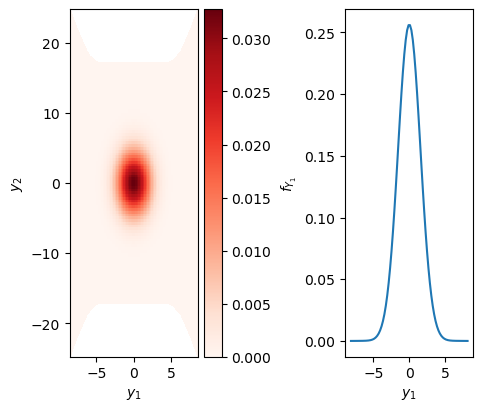

time t =  0.5


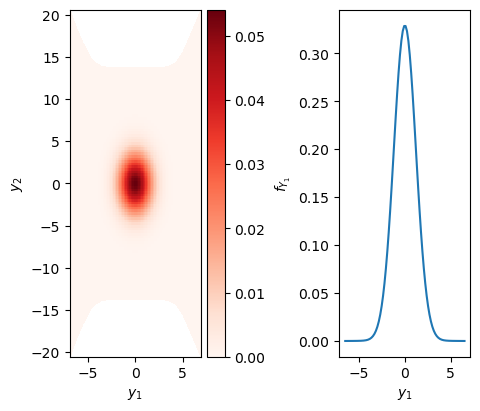

time t =  0.75


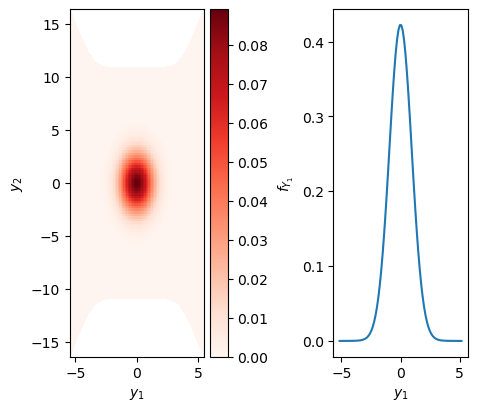

In [8]:
# Standard deviations for initial condition
σ1 = 2
Y1 = (erfinv(2*G(z1) - 1)*σ1*np.sqrt(2))

σ2 = 4
Y2 = (erfinv(2*G(z2_2d) - 1)*σ2*np.sqrt(2)).flatten()

dt = 0.001
nt = 1000

for i in range(nt):
    Y2 +=  L2 @ Y2 * dt
    Y1 +=  L1 @ Y1 * dt
    
    
    if i % (nt/4) == 0:
        print('time t = ',i*dt)
        #plot_mapping(z1,Y1, z1_2d,z2_2d,Y2)
        OUT = map_to_pdf(z1,Y1, z2_2d,Y2)
        plot_joint(*OUT)

The time evolution shows that the systems variance shrinks uniformally as the diffusive terms mix the contents of the domain. Furthermore no discernable covariance between $Y_1$ and $Y_2$ develops, which for buoyancy driven flows is not realistic. 

To account for this we now include the diffusive fluxes which for our system appear as forcing terms

\begin{align*}
\frac{\partial \mathscr{Y}_1 }{\partial t} &= \mathbf{D}^{(1)}_{1} + \frac{\gamma_{1}}{\tau_1(t)} \left( \frac{\partial^{2}}{\partial z_{1}^{2}} - z_1\frac{\partial }{ \partial z_1 }\right)\mathscr{Y}_1, \\
\frac{\partial \mathscr{Y}_2 }{\partial t} &= \mathbf{D}^{(1)}_{2} + \gamma_2 \left[ \frac{1}{\tau_1(t)} \left( \frac{\partial^{2}}{\partial z_{1}^{2}} - z_1\frac{\partial }{ \partial z_1 }\right) + \frac{1}{\tau_2(t)} \left( \frac{\partial^{2}}{\partial z_{2}^{2}} - z_2\frac{\partial }{ \partial z_2 }\right) \right] \mathscr{Y}_2.
\end{align*}

which in the form of our forward Kolmogorov equation are given by 

\begin{equation}
  \mathbf{D}^{(1)}_1 =
  \phi\,\mathbb{E}_{\mathbf{Y}_{t}|\partial\Omega} \left( \alpha_{1}\,\mathbf{n}\cdot\nabla Y^1_t \right) \frac{f_{\mathbf{Y}|\partial\Omega}}{f_{\mathbf{Y}}}.
\end{equation}

and

\begin{equation}
  \mathbf{D}^{(1)}_2 = y_1 - \mathbb{E}_{\mathbf{Y}_{t}} [\partial_{Z} P_{t}].
\end{equation}

For the first term $\mathbf{D}^{(1)}_1$ we will use the fact that the equation for $\tilde{Y}_1(\mathbf{x},t) = \mathscr{Y}_{1}(Z_1(J_1(t)\mathbf{x}),t)$ in the 2D system is identical to that of the 1D system in order to specify the forcing. For the second term $\mathbf{D}^{(1)}_2$ we can replace $y_1$ directly by $\mathscr{Y}_{1}$ by applying the mapping closure, however it remains to model the pressure term.

Ignoring the pressure term we consider a case where $\mathbf{D}^{(1)}_1$ corresponds to a forcing that supports a 2 layer stratification. Importing routines from the 1D problem we first generate a bimodal pdf corresponding to a 2 layer stratification. In order to have a grid on which we can mnake this calculation we must first specify initial conditions

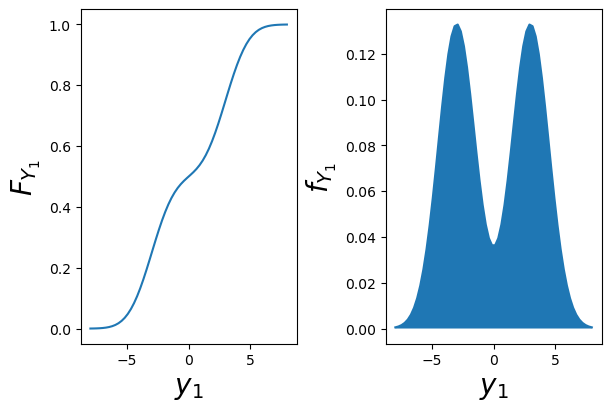

In [9]:
# Initial condition
σ1 = 2
Y1 = (erfinv(2*G(z1) - 1)*σ1*np.sqrt(2))

σ2 = 4
Y2 = (erfinv(2*G(z2_2d) - 1)*σ2*np.sqrt(2)).flatten()


# A) Generate a PDF corresponding to a two layer stratification

from Part2_Mapping_Stratification_1d import make_F_Y, make_f_Y

# Location of 'interface(s)'
loc = [-3, 3]  # Mean/height of the layer
std = [1.5, 1.5]  # Standard deviation of the layer
amp = [1, 1]  # Changes the maximum and minimum buoyancy of the layer

# Enforce normalisation
SUM = np.sum(amp)
amp = [i/SUM for i in amp]

F_Y1 = make_F_Y(loc, std, amp)
f_Y1 = make_f_Y(loc, std, amp)


# Visualise
fig = plt.figure(figsize=(6,4),layout='constrained')

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(Y1, F_Y1(Y1))
ax1.set_ylabel(r'$F_{Y_1}$', fontsize=20)
ax1.set_xlabel(r'$y_1$', fontsize=20)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(Y1, f_Y1(Y1))
ax2.fill_between(Y1, f_Y1(Y1))
ax2.set_ylabel(r'$f_{Y_1}$', fontsize=20)
ax2.set_xlabel(r'$y_1$', fontsize=20)

plt.show()

We then generate the forcing term $\mathbf{D}^{(1)}_1$ and the map $\mathscr{Y}_1$ required to produce this pdf.

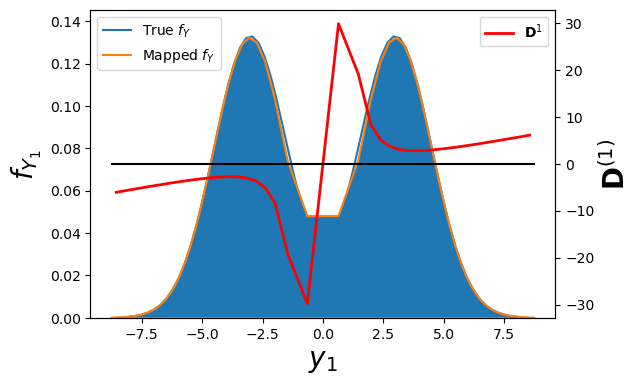

In [10]:
# B) Generate the forcing and the map Y_ required to produce this pdf

from Part2_Mapping_Stratification_1d import make_map

Y1_= make_map(F_Y1, z1)
F1 = -L1@Y1_ # Here we use F1 instead of D^(1)_1 for the forcing as D has been used in code to refer to derivatives

# Check the mapped pdf matches
dY_dz = grad(z1) @ Y1_
f1_   = g(z1)/dY_dz

fig = plt.figure(figsize=(6, 4))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(Y1, f_Y1(Y1), label=r'True $f_Y$')
ax1.plot(Y1_, f1_, label=r'Mapped $f_Y$')
ax1.fill_between(Y1_, f1_)
#ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.1*np.max(f1_)])
ax1.set_xlabel(r'$y_1$', fontsize=20)
ax1.set_ylabel(r'$f_{Y_1}$', fontsize=20)
ax1.legend(loc=2)

ax2.plot(Y1_[1:-1], F1[1:-1], '-r', linewidth=2, label=r'$\mathbf{D}^1$')
ax2.plot(Y1_, 0*Y1_, '-k')
#ax2.set_xlim([0, 1])
ax2.set_ylabel(r'$\mathbf{D}^{(1)}$', fontsize=20)
ax2.legend()

plt.show()

time t =  0.0


/tmp/ipykernel_1466/2180677631.py:78: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc=ax1.pcolormesh(y1_2d,y2_2d,f_12, cmap='Reds')#,linewidth=0, antialiased=False)


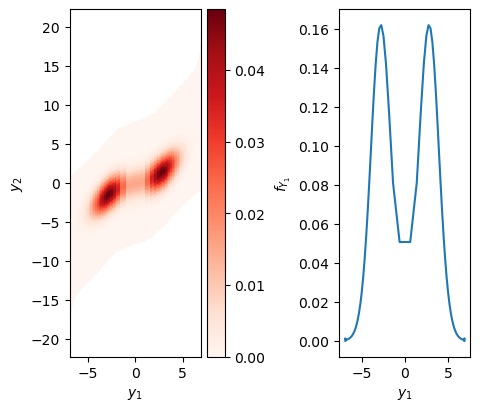

time t =  0.2


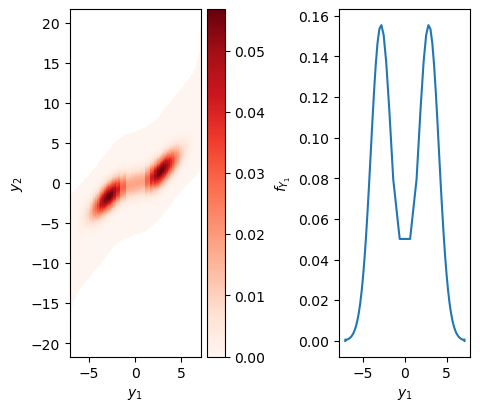

time t =  0.4


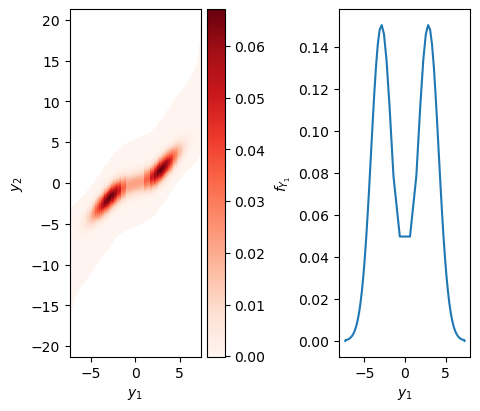

time t =  0.6


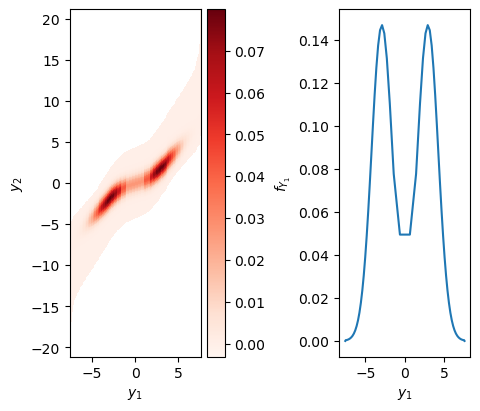

time t =  0.8


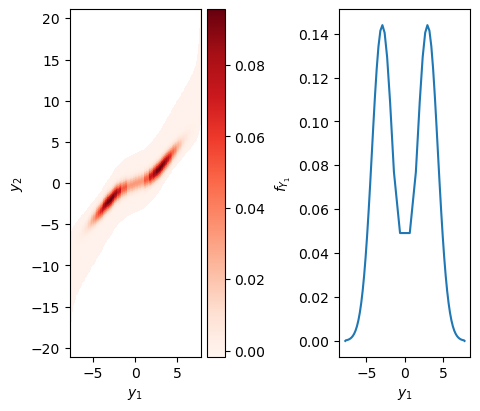

time t =  1.0


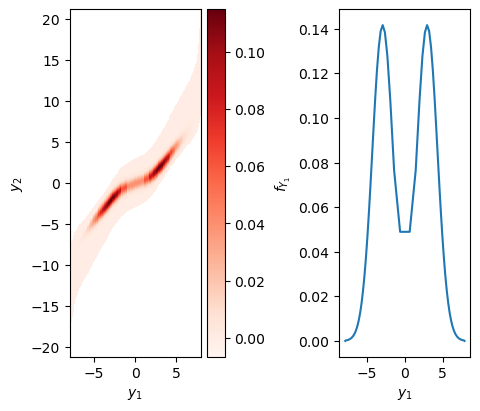

time t =  1.2


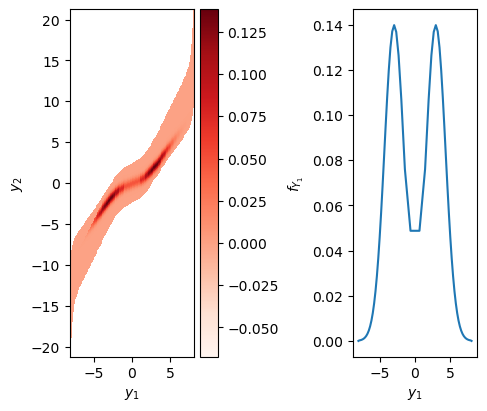

time t =  1.4000000000000001


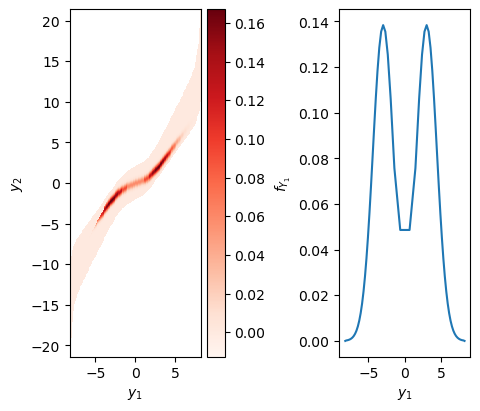

time t =  1.6


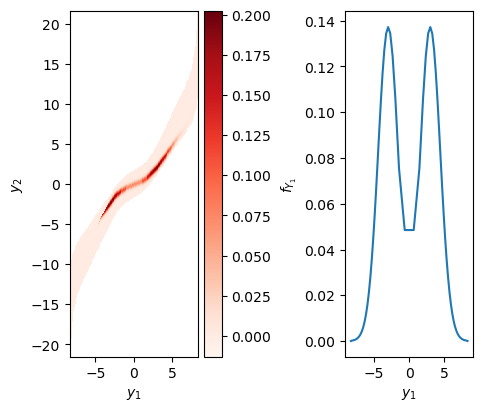

time t =  1.8


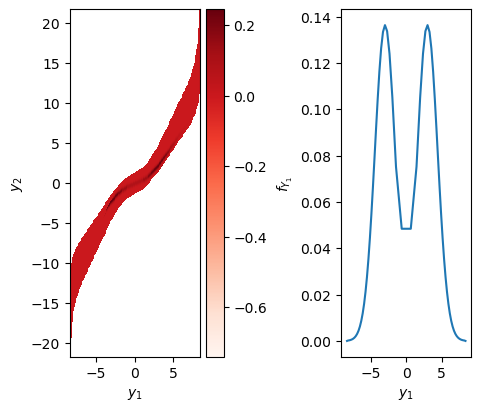

In [13]:
dt = 0.001
nt = 2000

for i in range(nt):
    Y2 += one_to_2d(Y1)*dt   +   L2 @ Y2* dt
    Y1 += F1 * dt            +  L1 @ Y1 * dt
    
    
    if i % (nt/10) == 0:
        print('time t = ',i*dt)
        #plot_mapping(z1,Y1, z1_2d,z2_2d,Y2)
        OUT = map_to_pdf(z1,Y1, z2_2d,Y2)
        plot_joint(*OUT)